# Evaluation task
Using the BPI Challenge 2012 dataset we will showcase the indicators that serve in guiding the identification of tasks and/or process properties that are eligible to be automated using RPA.
## Load Requirements

In [1]:
import os, sys, random, re 
import pandas as pd
import numpy as np
# Importing IEEE XES files 
from pm4py.objects.log.importer.xes import factory as xes_import_factory
# Apply PCA + DBSCAN clustering after creating a representation of the log; used in clusterlog()
from pm4pyclustering.algo.other.clustering import factory as clusterer 
# Retrieve the number of occurrences of the activities; used in execFreq()
from pm4py.algo.filtering.log.attributes import attributes_filter
# Retrieve variants and the number of occurence; used in execFreqCase()
from pm4py.statistics.traces.log import case_statistics
# Converts a log to interval format (e.g. an event has two timestamps) 
# from lifecycle format (an event has only a timestamp, and a transition lifecycle); used in execTime()
from pm4py.objects.log.util import interval_lifecycle
# Get the paths (pair activities) of the log along with their count; used in priorFollowVar()
from pm4py.algo.filtering.log.paths import paths_filter 
# get the functions defined 
from pm4RPA import clusterlog, getIndicators

## Import XES file

In [2]:
path = ".."
os.chdir(path)
filexes = "financial_log.xes"
log = xes_import_factory.apply(os.path.join(os.getcwd(), "data", filexes))
print("Event log loaded with number of traces:", len(log))

Event log loaded with number of traces: 13087


## Apply trace clustering
We transform the log to a log representation, using the string event attribute *concept:name* and the string trace attribute *AMOUNT\_REQ*. Clusters are obtained using *DBSCAN*, with $\epsilon$ parameter equal to $0.3$ and *MinPts* equal to $5$, applied to *PCA* projected data using 3 components.

In [3]:
clusterParams = {"str_ev_attr" : "concept:name", "str_tr_attr" :"AMOUNT_REQ" }
clusters = clusterlog(log,clusterParams)

Apply PCA + DBSCAN clustering from log representation obtained using  {'str_ev_attr': 'concept:name', 'str_tr_attr': 'AMOUNT_REQ'}
sublog 0  has  2369  traces
sublog 1  has  3480  traces
sublog 2  has  1216  traces
sublog 3  has  1131  traces
sublog 4  has  2225  traces
sublog 5  has  494  traces
sublog 6  has  1266  traces
sublog 7  has  883  traces
sublog 8  has  12  traces
sublog 9  has  5  traces
sublog 10  has  6  traces


## Obtain all indicators
* Execution Frequency
* Execution Frequency:case
* Execution Time
* Inverse Stability
* Prior/follow variability 

All indicators are calculated at an activity cluster level.

In [4]:
activityKey = 'concept:name'
indicators = getIndicators(clusters, activityKey)

Calculating Execution Frequency & Execution Frequency:case
Calculating Execution Time & Inverse Stability
Calculating Prior/follow variability


### Execution Frequency & Execution Frequency:case
Activities repeated often, i.e. those having high $EF(L^v)$ are candidates for RPA, however, those having a high $EF_{c}(L^v)$ should be investigated to understand the root causes of the repeats. 

In [5]:
# get dataframe sorted by Execution Frequency in each cluster 
indicators = indicators.groupby(["cluster"]).apply(lambda x: x.sort_values(["EF"], ascending = False)).reset_index(drop=True)
# get percentile rank for Execution Frequency: case
indicators['EFc_pct_rank'] = indicators['EFc'].rank(pct=True)
# select top N rows within each cluster
top3 = indicators.groupby('cluster').head(3)
indicators = indicators.drop(['EFc_pct_rank'], axis=1)
top3.groupby('activity').agg(ntop3=('activity', 'count'), mean_EFc_pct_rank=('EFc_pct_rank', 'mean')).sort_values(by=['ntop3'], ascending=False)

,ntop3,mean_EFc_pct_rank
activity,,
W_Afhandelen leads,6,0.913510
A_PARTLYSUBMITTED,5,0.651515
W_Completeren aanvraag,5,0.956818
W_Nabellen offertes,4,0.966856
W_Beoordelen fraude,3,0.951389
A_DECLINED,2,0.651515
A_SUBMITTED,2,0.651515
W_Nabellen incomplete dossiers,2,0.994318
W_Valideren aanvraag,2,0.935606


To this extent, W_Afhandelen leads is good candidate for RPA since it found 6 times in the top 3 per cluster ranking of the Execution Frequency. Nevertheless, it has a high value of the $EF_{c}(L^v)$ as per the mean percentile obtained, so it should be investigated.
### Execution Time

In [6]:
# get dataframe sorted by Execution Time in each cluster 
indicators = indicators.groupby(["cluster"]).apply(lambda x: x.sort_values(["ET"], ascending = False)).reset_index(drop=True)
# select top N rows within each cluster
top3 = indicators.groupby('cluster').head(3)
top3.groupby('activity').agg(ntop3=('activity', 'count'), mean_ET=('ET', 'mean')).sort_values(by=['ntop3'], ascending=False)

,ntop3,mean_ET
activity,,
W_Afhandelen leads,6,759.472013
W_Completeren aanvraag,6,497.565926
W_Beoordelen fraude,4,785.285698
W_Valideren aanvraag,4,1025.984939
A_FINALIZED,3,0.000000
W_Nabellen incomplete dossiers,3,654.383205
W_Nabellen offertes,2,547.069593
A_ACTIVATED,1,0.000000
A_PARTLYSUBMITTED,1,0.000000


### Inverse Stability

In [8]:
# get dataframe sorted by Execution Time in each cluster 
indicators = indicators.groupby(["cluster"]).apply(lambda x: x.sort_values(["ST"], ascending = False)).reset_index(drop=True)
# select top N rows within each cluster
top3 = indicators.groupby('cluster').head(3)
top3.groupby('activity').agg(ntop3=('activity', 'count'), mean_ST=('ST', 'mean')).sort_values(by=['ntop3'], ascending=False)

,ntop3,mean_ST
activity,,
W_Afhandelen leads,6,26264.128995
W_Completeren aanvraag,5,14537.728531
W_Beoordelen fraude,4,12511.429388
W_Nabellen offertes,4,43293.328912
A_FINALIZED,3,0.000000
W_Nabellen incomplete dossiers,3,26757.396738
W_Valideren aanvraag,3,3546.361596
A_ACTIVATED,1,0.000000
A_PARTLYSUBMITTED,1,0.000000


### Prior/follow variability

In [9]:
# get dataframe sorted by Execution Time in each cluster 
indicators = indicators.groupby(["cluster"]).apply(lambda x: x.sort_values(["PFv"], ascending = False)).reset_index(drop=True)
# select top N rows within each cluster
top3 = indicators.groupby('cluster').head(3)
top3.groupby('activity').agg(ntop3=('activity', 'count'), mean_PFv=('PFv', 'mean')).sort_values(by=['ntop3'], ascending=False)

,ntop3,mean_PFv
activity,,
A_PARTLYSUBMITTED,10,1.949267
A_PREACCEPTED,6,2.000000
A_DECLINED,5,1.796574
O_SENT,2,2.000000
O_SENT_BACK,2,1.471237
W_Beoordelen fraude,2,1.325000
A_CANCELLED,1,1.476623
A_REGISTERED,1,2.000000
A_SUBMITTED,1,1.000000


## Processes

In [10]:
# get percentile rank for Execution Frequency: case
indicators = indicators.drop(['EFc_pct_rank'], axis=1)

In [11]:
indicators.groupby(["cluster"]).agg(mean_EF=('EF', 'mean'), 
                                    mean_EFc=('EFc', 'mean'), 
                                    mean_ET=('ET', 'mean'),
                                    mean_ST=('ST', 'mean'), 
                                    mean_PFv=('PFv', 'mean'))

,mean_EF,mean_EFc,mean_ET,mean_ST,mean_PFv
cluster,,,,,
0,4144.833333,2.518479,128.495952,3720.003017,0.653704
1,448.375000,0.387255,27.427755,1156.915385,0.218139
2,774.500000,0.927837,34.211995,1572.573778,0.389044
3,845.250000,0.830386,65.134304,2330.061016,0.408964
4,596.750000,0.268202,42.160391,1137.682256,0.260417
5,719.250000,1.548413,80.394800,4305.542788,0.536005
6,1592.666667,1.351586,46.870979,2535.026290,0.520823
7,1775.208333,2.800161,187.516728,6326.374625,0.630773
8,19.458333,3.732008,101.138468,42.602996,1.199758


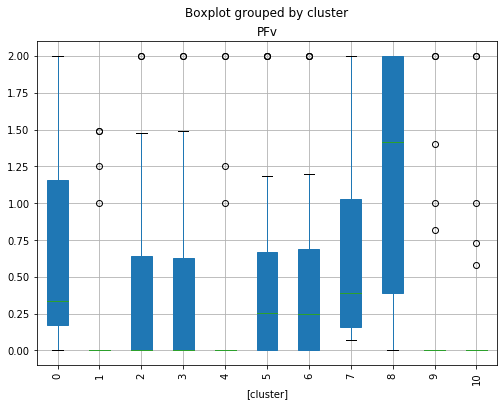

In [27]:
indicators.drop(['ST','EF','ET','EFc'], axis=1).boxplot(by='cluster',fontsize=10,rot=90,figsize=(8,6),patch_artist=True)

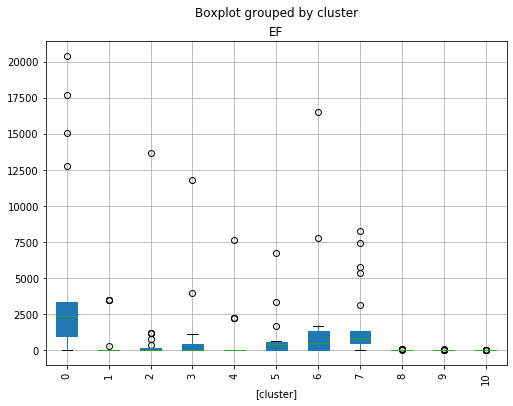

In [32]:
indicators.drop(['PFv','EFc','ET','ST'], axis=1).boxplot(by='cluster',fontsize=10,rot=90,figsize=(8,6),patch_artist=True)

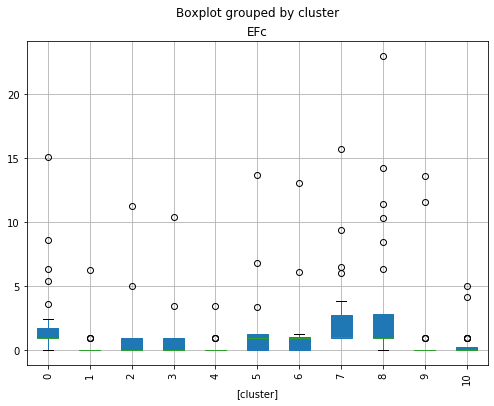

In [33]:
indicators.drop(['PFv','EF','ET','ST'], axis=1).boxplot(by='cluster',fontsize=10,rot=90,figsize=(8,6),patch_artist=True)

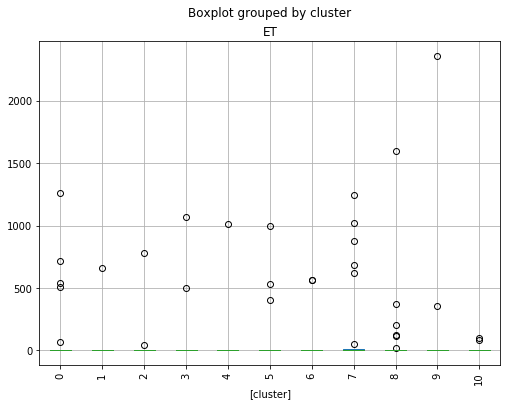

In [34]:
indicators.drop(['PFv','EF','EFc','ST'], axis=1).boxplot(by='cluster',fontsize=10,rot=90,figsize=(8,6),patch_artist=True)

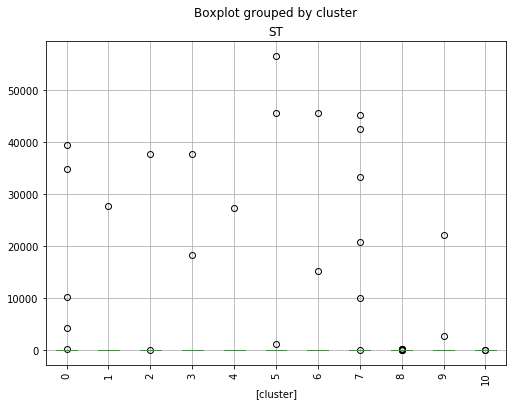

In [35]:
indicators.drop(['PFv','EF','EFc','ET'], axis=1).boxplot(by='cluster',fontsize=10,rot=90,figsize=(8,6),patch_artist=True)